<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-fitting" data-toc-modified-id="Model-fitting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model fitting</a></span></li><li><span><a href="#Prior-distribution" data-toc-modified-id="Prior-distribution-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prior distribution</a></span></li><li><span><a href="#Logistic-fits" data-toc-modified-id="Logistic-fits-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Logistic fits</a></span></li><li><span><a href="#Threshold---Gain-plot" data-toc-modified-id="Threshold---Gain-plot-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Threshold - Gain plot</a></span></li><li><span><a href="#Threshold---Asymmetry-plot" data-toc-modified-id="Threshold---Asymmetry-plot-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Threshold - Asymmetry plot</a></span></li></ul></div>

# Model fitting

```
$ python fitting_models.py i
```
where `i` is the seed number.



# Prior distribution

In [1]:
# load alpha that is fitted
import pickle as pkl
import numpy as np
savedir = 'res_fit_to_empirical2/'

x_opt = []
LSE = 99999
model_name = ''
LSE_s = []
x_opt_s = []
model_name_s = []


for ii in range(10):
    with open(savedir + 'res_fit{0}.pkl'.format(ii), 'rb') as f:
        data_1 = pkl.load(f)

    for i in range(len(data_1['res_s'])):
        LSE_s.append(data_1['res_s'][i]['fun'])
        x_opt_s.append(data_1['res_s'][i]['x'])
        if LSE > data_1['res_s'][i]['fun']:
            LSE = data_1['res_s'][i]['fun']
            x_opt = data_1['res_s'][i]['x']

idxxx = np.argsort(LSE_s)
xss = np.array(x_opt_s)
id = np.argmin(LSE_s)
print(xss[id])

[0.76650391]


In [2]:
from fitting_models import value_efficient_coding_moment, fitting_model_model

N_neurons = 39
R_t = 245.41
ec_moment = value_efficient_coding_moment(
    './', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH=xss[id], slope_scale = 5.07)

G:\My Drive\researches\codes\ec-publish\fitting_models.py:33: RuntimeWarning: divide by zero encountered in log
  self.x_log = np.log(self.x)  # np.linspace(-5, 5, num=int(1e3))
G:\My Drive\researches\codes\ec-publish\fitting_models.py:35: RuntimeWarning: divide by zero encountered in log
  self.x_log_inf = np.log(self.x_inf)


C:\ProgramData\Anaconda3\envs\base37\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


<IPython.core.display.Javascript object>


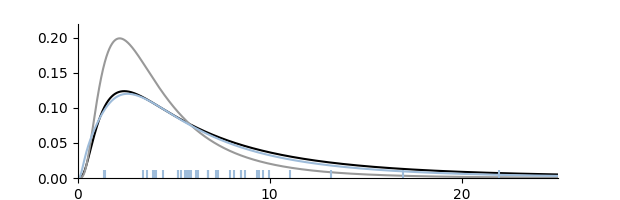

C:\ProgramData\Anaconda3\envs\base37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\envs\base37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
C:\ProgramData\Anaconda3\envs\base37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [3]:
import scipy.io as sio
import matplotlib.pyplot as plt

def log_kde(x, y, sigma, x_sample):
    """ calculates a log-normal based kernel density estimate
    based on samples at x with weights/probabilities y evaluated at x_sample"""
    # mean = exp(mu + sigma^2/2) != mtrue
    # -> mu = log(mtrue) - sigma^2/2
    mu = np.log(x) - (sigma ** 2 / 2)
    y_sample = np.zeros_like(x_sample)
    for mu_i, y_i in zip(mu, y):
        y_sample += (np.exp(-((np.log(x_sample) - mu_i) ** 2) / 2 / (sigma ** 2))
                     / np.sqrt(2 * np.pi) / sigma / x_sample) * y_i
    return y_sample

data = sio.loadmat('./measured_neurons/curve_fit_parameters.mat')['ps'] 
# "curve_fit_parameters.mat" is the file that contains logistic fits of neurons
# read './measured_neurons/CurveFit.ipynb' for more info
midpoints = data[np.setdiff1d(np.linspace(0,39,40).astype(np.int), 19),2]


%matplotlib notebook 
from matplotlib.path import Path
from matplotlib.patches import PathPatch
fig,ax = plt.subplots(1,1)
line2= ax.plot(ec_moment.x, ec_moment.d_x, color='k')

plt.plot(ec_moment.x[:8500], ec_moment.p_prior[:8500], color='#999999')

xs = np.log(ec_moment.x[:8500])
ys = log_kde(midpoints, np.ones(39)/39, .7, ec_moment.x[:8500])

plt.plot(ec_moment.x[:8500], ys,color='#9ebcda')
ax.vlines(midpoints, 0, .012*np.ones(midpoints.shape),colors='#9ebcda')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0, 25)
ax.set_ylim(0, .22)
ax.set_xticks([0,10,20])
fig.set_figwidth(6.2)
fig.set_figheight(2)


plt.savefig('./figures/midpoints.png',bbox_inches = 'tight')
plt.savefig('./figures/midpoints.pdf',bbox_inches = 'tight')

# Logistic fits

As mentioned, "curve_fit_parameters.mat"  contains result of logistic fits of neurons.

Read './measured_neurons/CurveFit.ipynb' for more info

In [4]:
# load sigmoid fit results
# read './measured_neurons/CurveFit.ipynb' for more info
import pickle as pkl
import scipy.io as sio

N_neurons = 39
R_t = 245.41
# `simpler=True`: simpler version of ec_moment
# only used to caclulate r_max_CI efficiently
ec = value_efficient_coding_moment(
    './', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH=0.766, slope_scale = 5.07, simpler=True)

dir_measured_neurons = 'measured_neurons/'

NDAT = sio.loadmat(dir_measured_neurons + 'data_max.mat')['dat']
data = sio.loadmat(dir_measured_neurons + 'curve_fit_parameters.mat')

indices = np.setdiff1d(np.linspace(0, 39, 40).astype(np.int16), 19) # except one neuron
param_set = [data['ps_lcb'][indices], data['ps']
             [indices], data['ps_ucb'][indices]]

G:\My Drive\researches\codes\ec-publish\fitting_models.py:33: RuntimeWarning: divide by zero encountered in log
  self.x_log = np.log(self.x)  # np.linspace(-5, 5, num=int(1e3))
G:\My Drive\researches\codes\ec-publish\fitting_models.py:35: RuntimeWarning: divide by zero encountered in log
  self.x_log_inf = np.log(self.x_inf)


In [5]:
# verify r_max_hat = 245.51 and get r_max's confidence interval

# curve
def sigmoid_func(x, a, b, c):
    return b / (1 + np.exp(-(x - c) * a))

# calculate r_max_hat
neurons_all_ = []
for i in range(len(ec.neurons_)):
    neurons_all_.append(sigmoid_func(
        ec.x, *data['ps'][indices][i, :]))
r_max_hat = np.sum([np.sum(np.array(neurons_all_[i]) * ec.p_prior * ec._x_gap)
            for i in range(len(neurons_all_))])
print(r_max_hat) # 245.41

# calculate r_max's confidence interval
neurons_all = []
for j in range(data['ps_total'][indices].shape[1]):
    neurons_all_ = []
    for i in range(len(ec.neurons_)):
        neurons_all_.append(sigmoid_func(
            ec.x, *data['ps_total'][indices][i, j, :]))
    neurons_all.append(neurons_all_)
    
r_max_CI  = [np.sum(np.array(neurons_all[i]) * ec.p_prior * ec._x_gap)
            for i in range(len(neurons_all))]
print('min {}, max {}'.format(min(r_max_CI),max(r_max_CI)))


C:\ProgramData\Anaconda3\envs\base37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


245.40911987446552
min 178.67799776800712, max 253.0370261317267


In [6]:
ps_bootstrap = sio.loadmat('./measured_neurons/curve_fit_bootstrap5.mat')['ps'] 

In [7]:
# bootstrapping confidence interval

# curve
def sigmoid_func(x, a, b, c):
    return b / (1 + np.exp(-(x - c) * a))

ps_bootstrap = sio.loadmat('./measured_neurons/curve_fit_bootstrap5.mat')['ps'] 
ps_bootstrap=ps_bootstrap[np.setdiff1d(np.linspace(0,39,40).astype(np.int), 19),:,:]


# calculate r_max's confidence interval
neurons_all = []
for j in range(ps_bootstrap.shape[1]):
    neurons_all_ = []
    for i in range(len(ec.neurons_)):
        neurons_all_.append(sigmoid_func(
            ec.x, *ps_bootstrap[i, j, :]))
    neurons_all.append(np.sum(np.array(neurons_all_) * ec.p_prior * ec._x_gap))
    
# r_max_CI  = [np.sum(np.array(neurons_all[i]) * ec.p_prior * ec._x_gap)
#             for i in range(len(neurons_all))]
# print('min {}, max {}'.format(min(r_max_CI),max(r_max_CI)))



C:\ProgramData\Anaconda3\envs\base37\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [8]:
min (neurons_all)


238.16321291996064

In [9]:
print(np.percentile(neurons_all, 2.5))
print(np.percentile(neurons_all, 97.5))
r_max_CI = np.linspace(np.percentile(neurons_all, 5), np.percentile(neurons_all, 95), 100)

241.45830996865052
249.3044773887211


In [10]:
# bootstrapping confidence interval

# curve
def sigmoid_func(x, a, b, c):
    return b / (1 + np.exp(-(x - c) * a))

ps_bootstrap = sio.loadmat('./measured_neurons/curve_fit_bootstrap_2.mat')['ps'] 
ps_bootstrap=ps_bootstrap[np.setdiff1d(np.linspace(0,39,40).astype(np.int), 19),:,:]


# calculate r_max's confidence interval
neurons_all = []
for j in range(ps_bootstrap.shape[1]):
    neurons_all_ = []
    for i in range(len(ec.neurons_)):
        neurons_all_.append(sigmoid_func(
            ec.x, *ps_bootstrap[i, j, :]))
    neurons_all.append(np.sum(np.array(neurons_all_) * ec.p_prior * ec._x_gap))
    
# r_max_CI  = [np.sum(np.array(neurons_all[i]) * ec.p_prior * ec._x_gap)
#             for i in range(len(neurons_all))]
# print('min {}, max {}'.format(min(r_max_CI),max(r_max_CI)))



C:\ProgramData\Anaconda3\envs\base37\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


# Threshold - Gain plot

In [11]:
print(np.percentile(neurons_all, 5))
print(np.percentile(neurons_all, 95))
r_max_CI = np.linspace(np.percentile(neurons_all, 5), np.percentile(neurons_all, 95), 100)

209.60268806865247
264.20863545143686


In [12]:
# load the fitted ec parameter: r_max
savedir = './res_fit/'

x_opt = []
LSE = 99999
model_name = ''
LSE_s = []
x_opt_s = []
model_name_s = []

for ii in range(1000):
    try:
        with open(savedir + 'res_fit_apprx_freealpha_freebeta_lognormal{0}.pkl'.format(ii), 'rb') as f:
            data_1 = pkl.load(f)

        for i in range(len(data_1['res_s'])):
            LSE_s.append(data_1['res_s'][i]['fun'])
            x_opt_s.append(data_1['res_s'][i]['x'])
            if LSE > data_1['res_s'][i]['fun']:
                LSE = data_1['res_s'][i]['fun']
                x_opt = data_1['res_s'][i]['x']
    except:
        ''

idxxx = np.argsort(LSE_s)
xss = np.array(x_opt_s)
id = np.argmin(LSE_s)

print(LSE_s[id]) # loss
print(xss[id]) # parameter fitted

5.84269654138492
[7.66666667]


In [13]:
# get rmax for every neurons... which is a constant value
ec_moment.replace_with_pseudo() # use high-definition
g_x_rstar = []
for i in range(len(ec_moment.neurons_)):
    g_x_rstar.append(xss[id][0])

# get asymmatric slopes 
# increase num_samples to int(1e4) 
tf, quantiles_constant, thresholds_constant, alphas, xs, ys = ec_moment.plot_approximate_kinky_fromsim_fitting_only_raw_rstar(
    ec_moment.neurons_, '.', r_star_param=g_x_rstar, num_samples=int(1e4))

In [14]:
# load details from Dabneys paper. refer to `./measured_neurons/dabney_matlab/`
import scipy.io as sio
fig5 = sio.loadmat("./measured_neurons/dabney_matlab/dabney_fit.mat")
fig5_betas = sio.loadmat("./measured_neurons/dabney_matlab/dabney_utility_fit.mat")
zero_crossings = fig5['zeroCrossings_all'][:, 0]
scaleFactNeg_all = fig5['scaleFactNeg_all'][:, 0]
scaleFactPos_all = fig5['scaleFactPos_all'][:, 0]
asymM_all = fig5['asymM_all'][:, 0]
ZC_true_label = fig5['utilityAxis'].squeeze()
ZC_estimator = lambda x: fig5_betas["betas"][0, 0] + fig5_betas["betas"][1, 0] * x
idx_to_maintain = np.where((scaleFactNeg_all * scaleFactPos_all) > 0)[0]
asymM_all = asymM_all[idx_to_maintain]
asymM_all_save = asymM_all.copy()
idx_sorted = np.argsort(asymM_all)
asymM_all = asymM_all[idx_sorted]
estimated_ = np.array(ec_moment.get_quantiles_RPs(asymM_all))
zero_crossings_ = fig5['zeroCrossings_all'][:, 0]
zero_crossings_ = zero_crossings_[idx_to_maintain]
zero_crossings_ = zero_crossings_[idx_sorted]
zero_crossings_estimated = ZC_estimator(zero_crossings_) # estimated thresholds

<IPython.core.display.Javascript object>


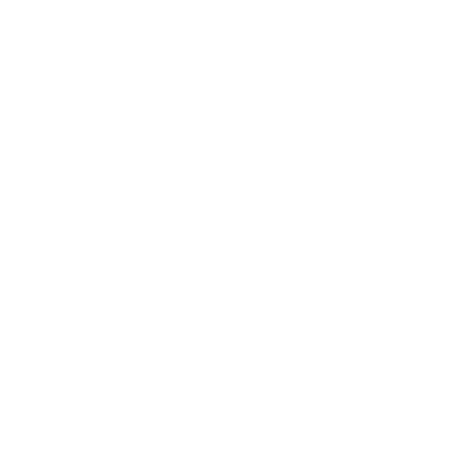

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [15]:
# non linear fit + bootstrap
fig4, ax4 = plt.subplots(1, 1)
idx_sorted_ = np.argsort(asymM_all_save)
# ax4.scatter(zero_crossings_estimated,  param_set[1][:, 1][idx_sorted_], s=10, color=[0,0,0])
import scipy
from scipy.optimize import curve_fit

hires_x = np.linspace(0, 15, 1000)
func = lambda x, a, b: a*(x) + b
# best_fit_ab, covar = curve_fit(func, NDAT['ZC'][0,0].squeeze(), param_set[1][:,1],
#                                absolute_sigma = True)
best_fit_ab, covar = curve_fit(func, zero_crossings_estimated, param_set[1][:,1][idx_sorted_],
                               absolute_sigma = True)


num_sim = int(5e3)
ps = []
for i in range(num_sim):
    i_sample = np.random.choice(np.linspace(0,len(zero_crossings_estimated)-1,len(zero_crossings_estimated),dtype=np.int16),len(zero_crossings_estimated))
    while True:
        try:
            fit_ab, covar = curve_fit(func, zero_crossings_estimated[i_sample], param_set[1][:,1][idx_sorted_][i_sample],
                                       absolute_sigma = True, p0=[1,1], maxfev=int(1e4))
        except:
            print('redo it with different random seed.')
        break
        
    ps.append(fit_ab)
    

scipy.stats.pearsonr(zero_crossings_estimated, param_set[1][:,1][idx_sorted_])


alpha_lin = np.linspace(.2, 1, len(r_max_CI))
rp1data = []
rp2data = []

y_RRs = []
for count, R in enumerate(np.sort(r_max_CI)):
    ec = value_efficient_coding_moment(
        './', N_neurons=N_neurons, R_t=R, X_OPT_ALPH=0.7665, slope_scale=5.07)
    ec.replace_with_pseudo()
    y_RRs.append(ec.g_x_pseudo)

    
y_RRs = np.asarray(y_RRs)
lower = np.percentile(y_RRs, 0, axis=0)
upper = np.percentile(y_RRs, 100, axis=0)
ax4.fill_between(ec.x_inf, lower, upper,
                 color = '#9ebcda', alpha = 1)    
# ax4.plot(ec.x_inf, ec.g_x_pseudo, '-', linewidth=1,
#              c='#9ebcda',alpha=1)

ax4.set_xticks([.1, .3, 1.2, 2.5, 5, 10, 20])
ax4.scatter(zero_crossings_estimated, param_set[1][:, 1][idx_sorted_], s=10, c=[0, 0, 0])
ysample = np.asarray([func(hires_x, *pi) for pi in ps])
lower = np.percentile(ysample, 5, axis=0)
upper = np.percentile(ysample, 95, axis=0)

ax4.plot(hires_x, func(hires_x, *best_fit_ab), 'black')
ax4.fill_between(hires_x, lower, upper,
                 color = 'black', alpha = 0.15)


ax4.set_xlim(0, 12)
ax4.set_ylim(0, 40)
fig4.set_figwidth(4.5)
fig4.set_figheight(4.5)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)


ax4.set_xlim(0, 12)
ax4.set_ylim(0, 40)
fig4.savefig(
    './figures/threshold-gain2-boot.png')
fig4.savefig(
    './figures/threshold-gain2-boot.pdf')
# for illustration
ax4.spines['left'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.set_xticks([])
ax4.set_yticks([])
fig4.savefig(
    './figures/threshold-gain2-boot3.pdf')
fig4.savefig(
    './figures/threshold-gain2-boot3.png')



In [16]:
print(np.percentile(neurons_all, 2.5))
print(np.percentile(neurons_all, 97.5))
r_max_CI = np.linspace(np.percentile(neurons_all, 2.5), np.percentile(neurons_all, 97.5), 100)

205.40082443565495
271.03015653745945


# Threshold - Asymmetry plot

<IPython.core.display.Javascript object>


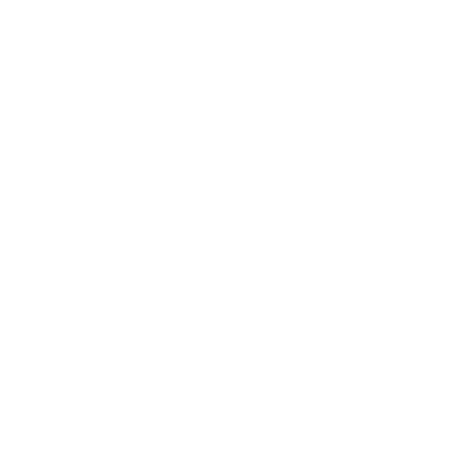

In [17]:

fig, ax = plt.subplots(1,1)
RPs = ec_moment.get_quantiles_RPs(quantiles_constant)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.scatter(zero_crossings_estimated, asymM_all, s=10, color='k')
ax.scatter(thresholds_constant, quantiles_constant, s=10, color='#9ebcda')
ax.set_xticks([.1, .3, 1.2, 2.5, 5, 10, 20])
ax.set_xlim([0, 12])
ax.set_ylim([0, 1])
plt.grid(False)
fig.set_figwidth(4.5)
fig.set_figheight(4.5)

RPSS = ec_moment.get_quantiles_RPs(np.linspace(0,1,1000))
# ax.plot(np.linspace(0,1,1000), RPSS, '--', color=[.7,.7,.7])
ax.plot(RPSS,np.linspace(0,1,1000), '--', color=[.7,.7,.7])

fig4.savefig(
    './figures/threshold-asymm.png')
plt.savefig(
    './figures/threshold-asymm.pdf')